In [21]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import copy as cp
import operator
import matplotlib.pyplot as plt
import random
from pythainlp.benchmarks.word_tokenization import benchmark
from preprocessing import preprocess #Our class
prepro = preprocess()
import extract_features
from sklearn.metrics import precision_recall_fscore_support
import pickle

In [23]:
#test_list = ['wisesight']; name = 'ws'; mode = 'train'; crf_v = 'ws1000'
test_list = ['wisesight-testset']; name = 'ws'; mode = 'test'; crf_v = 'ws1000'
#test_list = ['article','encyclopedia','news','novel']; name = 'best'; mode = 'train' ; crf_v = 'best'
#test_list = ['testset']; name = 'best'; mode = 'test'; crf_v = 'best'
#test_list = ['tnhc_train']; name = 'tnhc'; mode = 'train'; crf_v = 'tnhc'
#test_list = ['tnhc_test']; name = 'tnhc'; mode = 'test'; crf_v = 'tnhc'


#x,y_true = prepro.preprocess_x_y(test_list)
#y_true = [j for sub in y_true for j in sub if len(j) > 1]
#x = [j for sub in x for j in sub if len(j) > 1]

y_original = pickle.load(open(f'variable/y.pred.{name}.{mode}.vr', 'rb'))
y_entropy_original = pickle.load(open(f'variable/y.entropy.{name}.{mode}.vr', 'rb'))
y_prob_original = pickle.load(open(f'variable/y.prob.{name}.{mode}.vr', 'rb'))

x = pickle.load(open(f'variable/x.{name}.{mode}.vr', 'rb'))
y_true = pickle.load(open(f'variable/y.true.{name}.{mode}.vr', 'rb'))

In [24]:
x,y_true = prepro.preprocess_x_y(test_list)
# y_true = [j for sub in y_true for j in sub]
# x = [j for sub in x for j in sub]
y_true = [j for sub in y_true for j in sub if len(j) > 1]
x = [j for sub in x for j in sub if len(j) > 1]

t1_start = perf_counter()
y_original,y_entropy_original,y_prob_original,y_pred,y_entropy,y_ws,y_entropy_ws = prepro.predict_(x,og='true') # DeepCut Baseline/BEST+WS/WS
t1_stop = perf_counter()
dc_time = t1_stop-t1_start


In [25]:
import pycrfsuite
crf_model_og = pycrfsuite.Tagger() 
crf_model_og.open(f'model/crf_{crf_v}_entropyfrom_dc_bl_full_socialDict.model') # For baseline #Char type performwell on baseline
#crf_model_og.open('model/crf_best_entropyfrom_dc_bl_full_socialDict.model')
#crf_model_og.open('model/crf_tnhc_entropyfrom_dc_bl_full_SocialDict.model') 
#crf_model_og.open('model/I_just_want_to_try.model')



In [26]:
# # with open('model/LR_ws1000_bestmodel.sav', 'rb') as f:  # Python 3: open(..., 'wb')
# #     LR_model = pickle.load(f)
    
# # with open('model/LR_BEST_bestmodel.sav', 'rb') as f:  # Python 3: open(..., 'wb')
# #     LR_model = pickle.load(f)
    
# with open('model/LR_TNHC_bestmodel.sav', 'rb') as f:  # Python 3: open(..., 'wb')
#     LR_model = pickle.load(f)

In [27]:
def return_max_index(number_ranking,entropy_list):
    index_entropy = []
    func_entro_list = cp.deepcopy(entropy_list)
    ranking_ = int(len(entropy_list)*(number_ranking/100))
    #print(f'number we want is : {ranking_}')
    for i in range(ranking_):
        index, max_num = max(enumerate(func_entro_list), key=operator.itemgetter(1))
        func_entro_list[index] = -1.01
        index_entropy.append(index)
    return index_entropy

def scoring_function_crf(y_pred,index,mode='new'):
    result = y_pred[:]
    for i,items in enumerate(index):
        x_data = extract_features.extract_features_crf(x[i],i,y_entropy_original,y_prob_original)
        for idx in items:
            y_pred_crf = crf_model_og.tag(x_data[idx])
            result[i][idx] = int(y_pred_crf[0])
    return result

def scoring_function_lr(y_pred,index,mode='new'):
    result = y_pred[:]
    for i,items in enumerate(index):
        x_data = extract_features.extract_features_lstm(x[i],i,y_entropy_original,y_prob_original)
        for idx in items:
            y_pred_crf = LR_model.predict([x_data[idx]])
            result[i][idx] = int(y_pred_crf[0])
    return result

def scoring_function(y_true_,y_pred,index):
    result = y_pred[:]
    for idx,items in enumerate(index):
        for idx_item in items:
            try:
                result[idx][idx_item] = y_true_[idx][idx_item]
            except:
                print(f'random:{idx},{idx_item} result:{len(result)},{len(result[idx])} y_true:{len(y_true)},{len(y_true[idx])}')
    return result


In [28]:
def cut(y_pred_boolean,x_data):
    x_ = cp.deepcopy(x_data)
    answer = []
    for idx,items in enumerate(y_pred_boolean):
        text = ""
        for index,item in enumerate(items):
            if(item == 1):
                text +='|'
            text +=x_[idx][index]
        answer.append(text)
    return answer 

def eval_function(y_true,y_pred):
    f1_score_entropy=[]; 
    for index,_ in enumerate(y_pred):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true[index], y_pred[index], average='binary')
        #print(f'Precision:{precision}, Recall:{recall}, F1:{fscore}')
        f1_score_entropy.append(fscore)
    return np.mean(f1_score_entropy)

In [11]:
def score_(K_num=60,start=10,step=10):
    K_num+=step
    f1_original = []
    f1_crf_og=[]
    time_efficiency = []
    f1_hypothesis=[]
    y_true_data = [j for sub in y_true for j in sub]
    y_original_data = [j for sub in y_original for j in sub]
    for K in range(start,K_num,step):
        #print(f'Now K:{K}')
        #t1_start = perf_counter()  
        #start = time.time()
        entropy_index_og = [return_max_index(K,value) for value in y_entropy_original] # Find entropy index from DC Baseline
        
        
        answer_crf_original = scoring_function_crf(cp.deepcopy(y_original),entropy_index_og,mode='og') # CRF+DC(BEST+WS)
        #answer_crf_original = scoring_function_lr(cp.deepcopy(y_original),entropy_index_og,mode='og')
        
        y_test_data = [j for sub in answer_crf_original for j in sub]
        
        
        f1_original.append(eval_function([y_true_data],[y_original_data])) # F1 DeepCut(Baseline)
        f1_crf_og.append(eval_function([y_true_data],[y_test_data]))# F1 CRF+DeepCut(Baseline)
        
        #t1_stop = perf_counter() 
        #end = time.time()
        #time_efficiency.append(t1_stop-t1_start+dc_time)
        #time_efficiency.append(t1_stop-t1_start)
        answer = scoring_function(y_true,cp.deepcopy(y_original),entropy_index_og)
        f1_hypothesis.append(eval_function(y_true,answer))
        #time_efficiency.append(end-start)
        #print(time_efficiency)
        
    #%matplotlib notebook
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_xlabel('K percentage candidate',fontsize=18,fontname='Times New Roman')
    ax.set_ylabel('F1 Score Character level',fontsize=18,fontname='Times New Roman')
    #ax.plot(range(start,K_num,step),f1_hypothesis,c="r",marker='o',label='Best case')
    
    ax.plot(range(start,K_num,step),f1_original,c="k",label='DeepCut')
    ax.plot(range(start,K_num,step),f1_crf_og,c="g",marker='v',label='SE+DeepCut')
    
    ax.legend(loc='center right')
    #ax.legend()
    plt.show()
    #fig.savefig('f1_score_tnhc.eps', format='eps')
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.set_xlabel('K percentile',fontsize=18,fontname='Times New Roman')
#     ax.set_ylabel('Time (s)',fontsize=18,fontname='Times New Roman')
    #dc_time_array = np.full((len(range(start,K_num,step)),), dc_time)
    
    #ax.bar(range(start,K_num,step),dc_time_array,label='DeepCut',color='y', height=5)
    #ax.bar(range(start,K_num,step),time_efficiency,left=dc_time,label='SE+DC',color='g',height=5)
    #ax.bar(range(start,K_num,step),time_efficiency,width=4,label='Stacked Ensemble',color='k')
    #print('f1',f1_crf_og)
    #print('time',time_efficiency)
    #ax.legend(loc='lower left', bbox_to_anchor=(0., 1.02, 1., .102),ncol=2, mode="expand", borderaxespad=0.)
    #ax.legend(loc='upper left')
    #plt.show()
    #fig.savefig('running_time_tnhc.eps', format='eps')
    return f1_original,f1_crf_og,time_efficiency


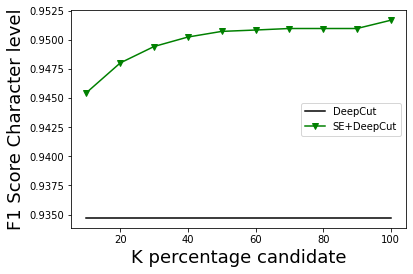

In [12]:
K_num = 100
start = 10
step = 10
f1_original,f1_crf_og,time_efficiency = score_(K_num=K_num,start=start,step=step)


In [11]:
max_gap_og = (f1_crf_og[0]-f1_original[0])*100
index_max_og = start
print(f"BL:{f1_original[0]:.5f}")
for idx,_ in enumerate(f1_crf_og):
    new_max_og = (f1_crf_og[idx]-f1_original[idx])*100
    index_now = start+(idx*step)

    if max_gap_og < new_max_og:
        max_gap_og = new_max_og
        index_max_og = index_now     
    
    print(f"K:{index_now} CRF_BL:{f1_crf_og[idx]:.7f} better than:{new_max_og:.4f}")
#print(f" CRF_NEWBL:{f1_crf_newbase[index_max-1]:.5f} CRF_BL:{f1_crf_og[index_max_og-1]:.5f}")    
print(f'index og:{index_max_og} ')
#print(f'index new baseline:{index_max} index og:{index_max_og}')


BL:0.93471
K:10 CRF_BL:0.9454771 better than:1.0765
K:20 CRF_BL:0.9480342 better than:1.3322
K:30 CRF_BL:0.9494473 better than:1.4735
K:40 CRF_BL:0.9502611 better than:1.5549
K:50 CRF_BL:0.9507463 better than:1.6034
K:60 CRF_BL:0.9508645 better than:1.6152
K:70 CRF_BL:0.9509950 better than:1.6283
K:80 CRF_BL:0.9509950 better than:1.6283
K:90 CRF_BL:0.9509950 better than:1.6283
K:100 CRF_BL:0.9517053 better than:1.6993
index og:100 


<h1>Change to final answer

In [29]:
def change_answer(entropy_y,y_deepcut,K_num,mode):
    entropy_index = [return_max_index(K_num,value) for value in entropy_y]
    answer_crf = scoring_function_crf(cp.deepcopy(y_deepcut),entropy_index,mode=mode)
    #answer_crf = scoring_function_lr(cp.deepcopy(y_deepcut),entropy_index,mode=mode)
    return answer_crf

In [30]:
# new og ws
y_pred_CRF_baseline = change_answer(y_entropy_original,y_original,K_num=100,mode='og') # set k to the best k value


In [31]:
y_true_data = [j for sub in y_true for j in sub]
y_original_data = [j for sub in y_original for j in sub]
y_pred_CRF_baseline = [j for sub in y_pred_CRF_baseline for j in sub]
x_data = ''
for item in x:
    x_data+=item
    
dc_pred = [y_original_data]
dc_pred = cut(dc_pred,[x_data])
true_pred = [y_true_data]
true_pred = cut(true_pred,[x_data])
crf_pred = [y_pred_CRF_baseline]
crf_pred = cut(crf_pred,[x_data])

from itertools import accumulate
import operator

def evaluate(train : list, test: list) -> tuple:
    train_acc = list(accumulate(map(len, train), func = operator.add))
    test_acc = list(accumulate(map(len, test), func = operator.add))
    train_set = set(zip([0,*train_acc], train_acc))
    test_set = set(zip([0,*test_acc], test_acc))
    correct = len(train_set & test_set)
    pre = correct/len(test)
    re = correct/len(test)
    f1 = (2*pre*re)/(pre+re)
    return f1

dc_list = dc_pred[0].split('|')
true_list = true_pred[0].split('|')
crf_list = crf_pred[0].split('|')
print('Char Score:',eval_function([y_true_data],[y_pred_CRF_baseline]))
#print('Baseline:',evaluate(true_list,dc_list))
print('Word Score:',evaluate(true_list,crf_list))


Char Score: 0.9517052526761265
Word Score: 0.8686618847390553


In [38]:
dg_correct = 0; dg_wrong = 0; ds_correct = 0; ds_wrong = 0;
for idx,val in enumerate(y_true_data):
    if y_original_data[idx] == val:
        dg_correct +=1
    else:
        dg_wrong +=1
    if y_pred_CRF_baseline[idx] == val:
        ds_correct +=1
    else:
        ds_wrong +=1

In [47]:
print(f'All data:{len(y_true_data)}')
print(f'DG correct:{dg_correct}DS correct:{ds_correct}')
print(f'DG wrong:{dg_wrong}\tDS wrong:{ds_wrong}')

All data:13529
DG correct:13005DS correct:13141
DG wrong:524	DS wrong:388


<h1> Back-up

In [17]:
# def list2word(l):
# 	data = []
# 	temp = ""
# 	for i,c in enumerate(l):
# 		if (c == 1 and i>0):
# 			data.append(temp)
# 			temp = ""
# 		temp += str(c)
# 		if i==len(l)-1:
# 			data.append(temp)
# 	return data

# def correct2(y_true,y_pred):
#     l_true = list2word(y_true)
#     l_pred = list2word(y_pred)
#     #print(l_true)
#     #print(l_pred)
#     correct = []
#     char_index = 0
#     for i,w in enumerate(l_pred):
#         #print(w)
#         if w in l_true:
#             if (y_true[char_index]+y_pred[char_index]==2 and y_true[char_index:char_index+len(w)-1]==y_pred[char_index:char_index+len(w)-1]): # ถ้า index char เป็น 1 ทั้งค่าจริงและทำนาย และ ถ้า list word นั้นเหมือนกันทั้งค่าจริงและทำนาย
#                 correct.append(w)
#         char_index+=len(w)
#     num_correct = len(correct)
#     precision = num_correct/len(l_pred)
#     recall = num_correct/len(l_true)
#     #print(precision,recall,correct)
#     try:
#         f1 = 2*precision*recall / (precision + recall)
#     except ZeroDivisionError:
#         f1=0.0
#     return precision,recall,f1


In [18]:
# y_true_data = [j for sub in y_true for j in sub]
# y_original_data = [j for sub in y_original for j in sub]

In [19]:
# f1,pre,re = correct2(y_true_data,y_original_data)
# f1_list = [f1]; pre_list = [pre]; re_list = [re]
# for k in range(10,110,10):
#     y_pred_CRF_baseline = change_answer(y_entropy_original,y_original,K_num=k,mode='og')
#     y_pred_CRF_baseline = [j for sub in y_pred_CRF_baseline for j in sub]
#     pre,re,f1 = correct2(y_true_data,y_pred_CRF_baseline)
#     f1_list.append(f1)
#     pre_list.append(pre)
#     re_list.append(re)

In [20]:
f1_list

[0.8839861179970253,
 0.9083023543990086,
 0.9120674686841127,
 0.913178487144454,
 0.913454364585924,
 0.914179104477612,
 0.9142928224903595,
 0.9144278606965174,
 0.9144278606965174,
 0.9144278606965174,
 0.9151107791884492]

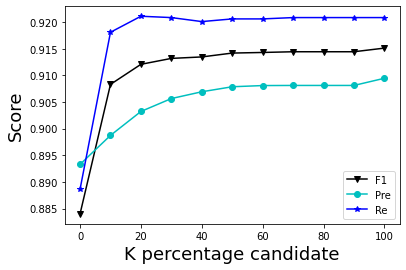

In [19]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_xlabel('K percentage candidate',fontsize=18,fontname='Times New Roman')
ax.set_ylabel('Score',fontsize=18,fontname='Times New Roman')

ax.plot(range(0,110,10),f1_list,c="k",marker='v',label='F1')
ax.plot(range(0,110,10),pre_list,c="c",marker='o',label='Pre')
ax.plot(range(0,110,10),re_list,c="b",marker='*',label='Re')
ax.legend(loc='bottom right')
#ax.legend()
plt.show()

In [62]:
correct2(y_true_data,y_pred_CRF_baseline)

{'precision': 0.8240605273352932,
 'recall': 0.7545594163947015,
 'f1': 0.7877800265348494}

In [63]:
correct2(y_true_data,y_original_data)

{'precision': 0.8229459122349473,
 'recall': 0.7572136853439282,
 'f1': 0.788712618645523}

In [17]:
# correct2wrong = 0
# wrong2correct = 0
# wrong2wrong = 0
# correct2correct = 0
# for idx,item in enumerate(y_true):
#     for index,_ in enumerate(item):
#         if y_true[idx][index] == y_original[idx][index] and y_original[idx][index] != y_pred_CRF_baseline[idx][index]:
#             correct2wrong+=1
#         elif y_true[idx][index] != y_original[idx][index] and y_true[idx][index] == y_pred_CRF_baseline[idx][index]:
#             wrong2correct+=1
#         elif y_true[idx][index] != y_original[idx][index] and y_true[idx][index] != y_pred_CRF_baseline[idx][index]:
#             wrong2wrong+=1
#         elif y_true[idx][index] == y_original[idx][index] and y_true[idx][index] == y_pred_CRF_baseline[idx][index]:
#             correct2correct+=1
# print('TNHC corpus')
# print(f"Correct->Wrong:{correct2wrong} Wrong->Correct:{wrong2correct}")
# print(f"Correct->Correct:{correct2correct} Wrong->Wrong:{wrong2wrong}")

TNHC corpus
Correct->Wrong:13260 Wrong->Correct:30407
Correct->Correct:829845 Wrong->Wrong:18012


In [25]:
x_true = cut(y_true,x) # actual result !

x_original = cut(y_original,x) # result DeepCut(Baseline)

x_crf_og = cut(y_pred_CRF_baseline,x) # result CRF+DeepCut(BEST+WiseSight) with the best k !

<h1>Result comparison

In [23]:
text='|แพง|เว่อร์| |เบียร์|ช้าง|ต้นทุน|ขวด|ละ|ไม่|ถึง| |50| |ขาย| |120| |😰|😰|😰์'.replace('|','')
text

'แพงเว่อร์ เบียร์ช้างต้นทุนขวดละไม่ถึง 50 ขาย 120 😰😰😰์'

In [76]:
i=59
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|หา|น้ำ|กิน| |#|ข่าว|ว่า|พรุ่ง|นี้|ภาษี|ขึ้น| |#|beer| |#|ubeer| |#|golf_eat_alot
DeepCut
|หา|น้ำกิน| |#|ข่าว|ว่า|พรุ่ง|นี้|ภาษี|ขึ้น| |#beer| #ubeer #golf_eat_alot
SE+DeepCut
|หา|น้ำกิน| |#|ข่าว|ว่า|พรุ่ง|นี้|ภาษี|ขึ้น| |#|beer| |#|ubeer| |#|golf_eat_alot
###########################################


In [79]:
i=61
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|มาสด้า| |ซีเอ็กซ์-3| |สนุก|กัน|อีก|สัก|ดอก
DeepCut
|มาสด้า ซีเอ็กซ์|-|3| |สนุก|กัน|อีก|สัก|ดอก
SE+DeepCut
|มาสด้า| |ซีเอ็กซ์-|3| |สนุก|กัน|อีก|สัก|ดอก
###########################################


In [100]:
i=81
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|เมื่อ|วาน|ชานม|ไข่มุก|ก็|อร่อย| |วันนี้|รุ่น|พี่|ก็|อร่อย| |//|สูด|กาว|วาด|ไม่|ทัน|แล้ว| |#|เต็นสิค
DeepCut
|เมื่อ|วานชาน|ม|ไข่|มุก|ก็|อร่อย| |วัน|นี้|รุ่น|พี่|ก็|อร่อย| |/|/|สูด|กาววาด|ไม่|ทัน|แล้ว| |#เต็น|สิค
SE+DeepCut
|เมื่อ|วาน|ชานม|ไข่|มุก|ก็|อร่อย| |วัน|นี้|รุ่น|พี่|ก็|อร่อย| |//|สูด|กาววาด|ไม่|ทัน|แล้ว| |#|เต็น|สิค
###########################################


In [102]:
i=83
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|เคเอฟซี| |บาร์บีกอน
DeepCut
|เคเอฟซี บาร์บีกอน
SE+DeepCut
|เคเอฟซี| |บาร์บีกอน
###########################################


In [110]:
i=91
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|เห้ย|น่า|ไป|ๆ|ๆ| |จิบ|เบียร์|ฟัง|ดนตรี| |งาน|ดี|ๆ|แบบ|นี้|ต้อง|ไม่|พลาด| #|chang
DeepCut
|เห้ยน่า|ไป|ๆ|ๆ| |จิบ|เบียร์|ฟัง|ดนตรี| |งาน|ดี|ๆ|แบบ|นี้|ต้อง|ไม่|พลาด| |#chang
SE+DeepCut
|เห้ย|น่า|ไป|ๆ|ๆ| |จิบ|เบียร์|ฟัง|ดนตรี| |งาน|ดี|ๆ|แบบ|นี้|ต้อง|ไม่|พลาด| |#|chang
###########################################


In [22]:
text = x_true[100]

In [24]:
text.replace('|','')

'ชอบ Honda Civic เพราะมันคล่องตัวและกว้างเหมาะกับการใช้งาน Eveeve Eve แกไปดูกะชั้นนะ #ฮอนด้าที่รัก #EnjoyHondaThailand'

In [21]:
i=100
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i].replace('|','')}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

SyntaxError: f-string: mismatched '(', '{', or '[' (<ipython-input-21-cbfe3131e17b>, line 3)

<h1>Create corpus

In [ ]:
# import pandas as pd
# y_pred_df = cp.deepcopy(y_original)

In [ ]:
# data = []
# for index,items in enumerate(y_true):
#     for idx,item in enumerate(items):
#         #if y_true[index][idx] != y_pred_2[index][idx] and x[index][idx] != '\n':
#         if x[index][idx] not in ['\n','\r\n','\r']:
#             text = ''
#             if idx < 4:
#                 for _ in range(4-idx):
#                     text += ' '
#                 text += x[index][:idx+3]
#             else:
#                 text = x[index][idx-4:idx+3]
#             if(len(text)<7):
#                 for _ in range(7-len(text)):
#                     text += ' '
#             #print(f"index:{index,idx} true:{y_true[index][idx]} pred:{y_pred_2[index][idx]} #entropy:{y_entropy[index][idx]} char:{x[index][idx]} sequence:{x[index][idx-5:idx+7]}")
#             data.append([text,y_entropy_original[index][idx],y_true[index][idx],y_pred_df[index][idx]]) 
            

In [ ]:
# df = pd.DataFrame(data,columns =['Char_sequence', 'Entropy','true_pred','pred']) 
# df = df.dropna()
# df

In [ ]:
#df.to_csv('corpus/ws1000_entropy_deepcut_bl_entropy_mul2.csv',index=False)

In [8]:
import pandas as pd
y_pred_df = cp.deepcopy(y_original)

In [9]:
data = []
for index,items in enumerate(y_true):
    for idx,item in enumerate(items):
        #if y_true[index][idx] != y_pred_2[index][idx] and x[index][idx] != '\n':
        if x[index][idx] not in ['\n','\r\n','\r']:
            text = x[index][:idx]+f"[{x[index][idx]}]"+x[index][idx+1:idx+20]
            #print(f"index:{index,idx} true:{y_true[index][idx]} pred:{y_pred_2[index][idx]} #entropy:{y_entropy[index][idx]} char:{x[index][idx]} sequence:{x[index][idx-5:idx+7]}")
            data.append([text,y_entropy_original[index][idx],'WS160',y_true[index][idx],y_pred_df[index][idx]]) 
            

In [11]:
df = pd.DataFrame(data,columns =['Sentence', 'Entropy','Corpus','Actual','Predic']) 
df = df.dropna()
df

,Sentence,Entropy,Corpus,Actual,Predic
0,[E]ucerin pro acne ค่ะ,0.000210,WS160,1,1
1,E[u]cerin pro acne ค่ะ,0.000000,WS160,0,0
2,Eu[c]erin pro acne ค่ะ ใ,0.000000,WS160,0,0
3,Euc[e]rin pro acne ค่ะ ใช,0.000000,WS160,0,0
4,Euce[r]in pro acne ค่ะ ใช้,0.000096,WS160,0,0
...,...,...,...,...,...
13524,อยากกิงบาบีก้อนบุฟอีกอ่ะ ทำไมมันยังไม่บุฟ คิดถ...,0.000000,WS160,0,0
13525,อยากกิงบาบีก้อนบุฟอีกอ่ะ ทำไมมันยังไม่บุฟ คิดถ...,0.000000,WS160,0,0
13526,อยากกิงบาบีก้อนบุฟอีกอ่ะ ทำไมมันยังไม่บุฟ คิดถ...,0.406927,WS160,1,1
13527,อยากกิงบาบีก้อนบุฟอีกอ่ะ ทำไมมันยังไม่บุฟ คิดถ...,0.000000,WS160,0,0


In [12]:
df.to_csv('corpus/ws160_comparison_corpus_only.csv',index=False)